# Your Final Project Title

- Vicky Xie: LMAO
- Riley Smith: put their contribution here
- Finnley O'Rourke: put their contribution here
- Kayla Katakis: ...

In [1]:
# Install Neccesary Packages

!pip install textblob
!pip install nltk 
!pip install -U textblob
!pip install bokeh

# Import Necessary Libraries

import pandas as pd
import re
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

# Downloading and Setting Up the Stopwords Package and Stemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached regex-2023.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
  Using cached bokeh-3.1.1-py3-none-any.whl (8.3 MB)
  Using cached xyzservices-2023.5.0-py3-none-any.whl (56 kB)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction

Our project focuses on the use of sentiment analysis and natural language processing in order to extract data from tweets regarding the Boston Marathon Bombings and Hurricane Sandy. The datasets observed looks at tweets in the aftermath of the both disasters, some of which are classified as “on topic” and others that are classified as “off-topic”. The “on-topic” tweets refer directly to the bombing or the hurricane while the “off-topic” tweets are about anything else. 
 
In order to extrapolate specific types of data from the data set our group used both VaderSentiment and TextBlob which helped create sentiment analysis scores for the various tweets. While both VaderSentiment and TextBlob are repositories that help coders perform sentiment analysis there are a few key differences that create variance within the data. 

Some of the differences between the two models include sentiment intensity vs. sentiment polarity. VaderSentimet uses a rule-based analysis in order to assign an intensity score (-1 to 1) to a given dataset. In contrast TextBlob uses a few different components like part-of-speech tagging and noun phrase extraction in order to assign a given tweet a polarity score (negative, neutral, or positive). Additionally, VaderSentiment is designed to incorporate other aspects of tweets such as emojis and capitalization which helps the program discern the level of sentiment.

# Research Questions

In this project, we will perform sentiment analysis and topic modeling to answer the following questions:
- How do Vader and TextBlob differ in creating sentiment scores for on topic tweets in regards to the Boston Marathon Bombings?
- How do Vader and TextBlob differ in creating sentiment scores for on-topic tweets about man-made disasters (Boston Marathon Bombing) versus natural disasters (Hurricane Sandy)?
- What are the main topic cluster that crop up in the tweets that are ‘on-topic’ in regards to the Boston Marathon Bombings? 
- How do they compare to the ‘on-topic’ topic clusters in the Hurricane Sandy tweets?

# Dataset Description

The Boston Bombings dataset takes looks at just over 10,000 tweets that are either about the Boston Marathon bombings or about other random topics. The Boston Bombings dataset has 3 columns.

- `label` - a string that indicates whether or not the tweet/observation is about the Boston Marathon Bombings , can either be ‘on-topic’ or ‘off-topic’
- `tweet id` - a string that gives each observation a unique identifier value
- `tweet` - a string that  represents the entire text of each unique tweet

Using the describe() function, we can see the the number of values for each column (count), and how many of those values are unique (unique). Additionally, we can see the ‘top’ value, which represents the most common value , and its frequency. For this dataset, there are 10,012 tweet id’s that are all unique and 10,012 total tweets, with 9,226 of those being unique. We see that our “top” id value only has a frequency of one, which is intuitive due to the unique nature of that variable. Our “top” tweet is actually a retweet that shows up 34 times in the dataset, meaning that there is likely an original tweet that was retweeted 34 times. There are only two unique “label” values, either on-topic or off-topic, with the more common label being on-topic with a count of 5,648.

The Hurricane Sandy dataset is structured identically to the Boston Bombing dataset, with the same 3 columns. The major difference, of coursse, is that being “on-topic” now refers to tweets that are directly related to Hurricane Sandy as opposed to the Boston Marathon Bombings. 

Using the describe() function on the Hurricane Sandy dataframe, we can see that there is nearly an equal number of tweets, with Hurricane Sandy having 10,008 tweets, each with their own unique id. Of the 10,008 tweets, 9,431 are unique with two potential labels, either on or off topic, which is the same as before. Similarly to the Boston Bombing data frame, the "top" tweet in this dataset is in the form of a retweet with a frequency of 28, meaning there is a likely an original tweet, and its retweets come up 28 times in this dataset. The more common label in this dataset is on-topic with a count of 6,138.

## 2013 Boston Bombing DF

In [2]:
df=pd.read_csv("2013_Boston_Bombings-ontopic_offtopic.csv")
df.describe()

,tweet id,tweet,label
count,10012,10012,10012
unique,10012,9226,2
top,'325208201740029952',RT @DannyAmendola: I will DONATE $100 for EVER...,on-topic
freq,1,34,5648


## 2012 Sandy Hurricane DF

In [3]:
df1=pd.read_csv("2012_Sandy_Hurricane-ontopic_offtopic.csv")
df1.describe()

,tweet id,tweet,label
count,10008,10008,10008
unique,10008,9431,2
top,'262596552399396864',"RT @HurricaneSandyw: FOR EVERY 100 RETWEETS, W...",on-topic
freq,1,28,6138


# Preprocessing

Before we begin analyzing the data, we first need to clean up our `tweet` column to get rid of any unnecessary information. 
To do so, we wrote a function called clean_text() that removes URLs, hashtags, mentions, and any unnecessary whitespace from the text to make sure that only the most meaningful aspects of the text are left for analysis. 

Additionally, our research questions revolve entirely around the on-topic tweets, so we will filter our datasets to include only these tweets to make our analysis easier and more efficient. We will also drop any empty tweets from the dataset.

In [4]:
# text cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text) # remove hashtag
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

## Boston Bombing

In [5]:
# apply the cleaning function to dataframe: Boston Bombing
df['clean_text'] = df.loc[(df[' label'] == 'on-topic')][' tweet'].apply(clean_text)
df=df.dropna(subset = ['clean_text'])

# test to make sure it worked
df['clean_text'].head()



2     This is fucking crazy. Suspect 2 has like 2 ho...
5     Back Bay Businesses Large And Small Affected B...
9     9000 agents/officers working for 14 hours, so ...
17    Tough to grasp what's happening right now in ....
19    Thank you to everyone who is keeping our city ...
Name: clean_text, dtype: object

## Hurricane Sandy

In [6]:
# apply the function to dataframe: Hurricane Sandy
df1['clean_text'] = df1.loc[(df1[' label'] == 'on-topic')][' tweet'].apply(clean_text)
df1=df1.dropna(subset = ['clean_text'])

# test to make sure it worked
df1['clean_text'].head()


1     Sandy be soooo mad that she be shattering our ...
5     Neighborly duties. arrives to the rescue sport...
7     I don't know how I'm getting back to Jersey si...
10              Already flooded so much SANDY @ Hoboken
12    On that note, i pray that everyone stays safe,...
Name: clean_text, dtype: object

# Analysis

For our analysis, we chose to use Sentiment Analysis and Topic Modeling. Because we are interesteed in the way people tweet about both man-made and natural disasters, we felt that Sentiment Analysis would be a great way to judge how people use Twitter to either sympathize with our create positivity from these disasters. Additionally, Topic Modeling can help us understand what common themes pop up in tweets about these disasters and help us understand how people react when these events occur.

# Sentiment Analysis

In order to carry out our Sentiment Analysis, we first had to develop a few functions that we can then apply to our two datasets using both TextBlob and Vader. 

Our first function `get_sentiment_textblob()` takes in a text value, which will be each tweet in the dataset, and then using the TextBlob package to return a sentiment score label. Any score greater than 0 is 'Positive' sentiment, less than 0 is 'Negative', and equal to 0 is 'Neutral'. Our other TextBlob function, `get_sent_textblob_cont()` takes each tweet and returns the numerical, continuous sentiment score.

We also have `get_sentiment_vader()` that works the same way and gives tweets a 'Positive' label to tweets with a score of 0.05 or higher, 'Negative' when the score is less than -0.05, and 'Neutral' if the score is between those two values. Since the Vader library uses more aspects of the tweets, such as capitalizations and emojis, we chose to give the Vader functions a slightly wider range for neutral tweets to account for the larger scope of variables that go into calculating the score.  Similarly to its TextBlob counterpart, `get_sent_vader_cont()` takes each tweet and returns its numerical, continuous sentiment score.

Then we apply all four of our functions to each of our two datasets to create dataframes that include each unique tweet and the sentiment scores and labels from each library.

In [7]:
# Define a function for sentiment analysis using TextBlob
def get_sentiment_textblob(text):
    """
    this function takes text as the input and calculates the sentiment score of this given text.
    """
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "Positive"
    elif sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

# get continuous textblob sentiment scores
def get_sent_textblob_cont(text):
    return TextBlob(text).sentiment.polarity

# Define a function for sentiment analysis using NLTK's Vader
def get_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    if sentiment['compound'] > 0.05:
        return "Positive"
    elif sentiment['compound'] < -0.05:
        return "Negative"
    else:
        return "Neutral"
    
# get continuous vader sentiment scores
def get_sent_vader_cont(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

## Boston Bombing

In [8]:
#Apply Snetiment Analysis functions to the Boston Bombings dataset
df['sentiment_textblob'] = df['clean_text'].apply(get_sentiment_textblob)
df['sent_textblob_cont'] = df['clean_text'].apply(get_sent_textblob_cont)
df['sentiment_vader'] = df['clean_text'].apply(get_sentiment_vader)
df['sent_vader_cont'] = df['clean_text'].apply(get_sent_vader_cont)
df[["clean_text", "sentiment_textblob", "sent_textblob_cont", "sentiment_vader", "sent_vader_cont"]]

,clean_text,sentiment_textblob,sent_textblob_cont,sentiment_vader,sent_vader_cont
2,This is fucking crazy. Suspect 2 has like 2 ho...,Negative,-0.600000,Negative,-0.3962
5,Back Bay Businesses Large And Small Affected B...,Negative,-0.011905,Negative,-0.1531
9,"9000 agents/officers working for 14 hours, so ...",Positive,0.200000,Positive,0.5233
17,Tough to grasp what's happening right now in ....,Positive,0.132275,Positive,0.8519
19,Thank you to everyone who is keeping our city ...,Positive,0.500000,Positive,0.8271
...,...,...,...,...,...
10007,RT : Boston bombing suspects’ dad says sons we...,Negative,-0.250000,Neutral,0.0000
10008,"Like the boston marathon, on a episode peter h...",Neutral,0.000000,Negative,-0.4939
10009,RT : MUST WATCH: Bruins fans sing emotional Na...,Negative,-0.050000,Positive,0.1531
10010,RT : So that Boston bombing was fake just like...,Negative,-0.500000,Negative,-0.1531


## Hurricane Sandy

In [9]:
#Applying Sentiment Analysis Functions to Hurricane Sandy Dataset
df1['sentiment_textblob'] = df1['clean_text'].apply(get_sentiment_textblob)
df1['sent_textblob_cont'] = df1['clean_text'].apply(get_sent_textblob_cont)
df1['sentiment_vader'] = df1['clean_text'].apply(get_sentiment_vader)
df1['sent_vader_cont'] = df1['clean_text'].apply(get_sent_vader_cont)
df1[["clean_text", "sentiment_textblob", "sent_textblob_cont", "sentiment_vader", "sent_vader_cont"]]

,clean_text,sentiment_textblob,sent_textblob_cont,sentiment_vader,sent_vader_cont
1,Sandy be soooo mad that she be shattering our ...,Negative,-0.625000,Negative,-0.4939
5,Neighborly duties. arrives to the rescue sport...,Neutral,0.000000,Positive,0.5106
7,I don't know how I'm getting back to Jersey si...,Neutral,0.000000,Neutral,0.0000
10,Already flooded so much SANDY @ Hoboken,Positive,0.200000,Neutral,0.0000
12,"On that note, i pray that everyone stays safe,...",Positive,0.392045,Positive,0.8439
...,...,...,...,...,...
10003,sandy is a weak name for a hurricane,Negative,-0.375000,Negative,-0.4404
10004,so freaking excited :D and i don't know...i ha...,Positive,0.687500,Positive,0.6975
10005,RT : I don't find these hurricane jokes funny....,Positive,0.250000,Positive,0.5994
10006,Best wishes to our friends in the northeast. S...,Positive,0.812500,Positive,0.9020


# Sentiment Analysis Visualization 

To analyze the difference between Vader and TextBlob in creating sentiment scores, we used bar plots that are color coded to represent the different libraries. TextBlob counts are shown in coral, Vader in periwinkle, and any overlapping counts are shown in purple. To create these plots, we used Seaborns countplot() function to create two layers of the plot, one with the continuous scores from the TextBlob functions, and one with the continous scores from Vader. 

## Boston Bombing

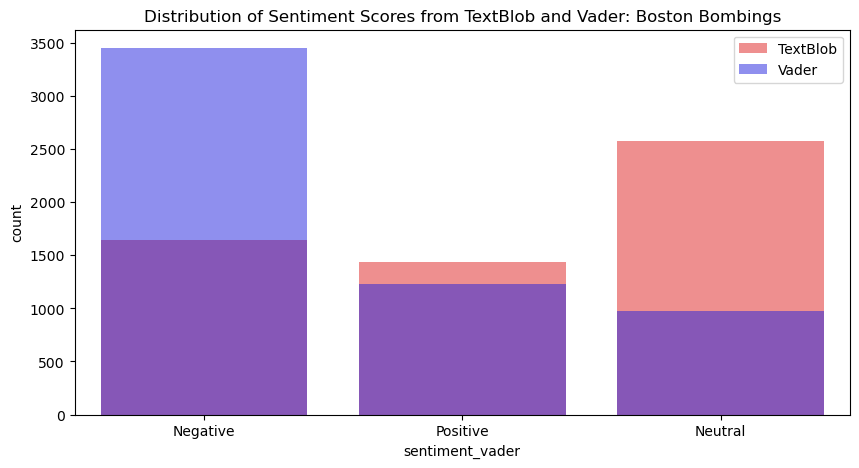

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(x="sentiment_textblob", data= df , label="TextBlob", color='r', alpha=0.5)
sns.countplot(x="sentiment_vader", data= df , label="Vader", color='b', alpha=0.5)
plt.legend()
plt.title('Distribution of Sentiment Scores from TextBlob and Vader: Boston Bombings')
plt.show()

## Hurricane Sandy

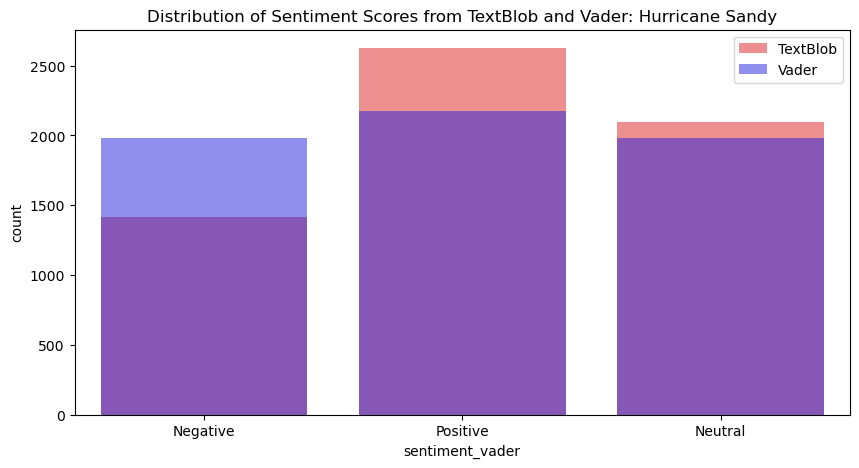

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(x="sentiment_textblob", data=df1, label="TextBlob", color='r', alpha=0.5)
sns.countplot(x="sentiment_vader", data=df1 , label="Vader", color='b', alpha=0.5)
plt.legend()
plt.title('Distribution of Sentiment Scores from TextBlob and Vader: Hurricane Sandy')
plt.show()

# Sentiment Analysis Results/Findings

Taking a look at our first research question, we can see that there are major disparities in the way that TextBlob and Vader calculate sentiment scores for the Boston Bombings tweets. Vader produced nearly twice as many "negative" labels as TextBlob, while the opposite effect occurred in "neutral" tweets. The positive tweets from both libraries are much fewer in frequencies, but TextBlob and Vader label them very similarly. Since Vader has a wider scope of what gets included in calculating the score, it would be a reasonable assumption that the emojis and capitalizations used in these tweets provide more negative context in a addition to the words written. Without these non-textual cues and components, these tweets can be defined as more neutral as they are in TextBlob's processing. In other words, these disparities in how the tweets are processed can show us how important non-textual aspects of written communication can be important in understanding context.

In regards to comparing TextBlob and Vader's processing capabilities between man-made (Boston Bombing) and natural (Hurricane Sandy) disasters, we can clearly see a lot less variability between the two libraries when it comes to Hurricane Sandy. The overall trends are the same with Hurricane Sandy as they are with the Bombings: Vader produces more negative labels while TextBlob produces more positive and neutral labels. However, these differences are much less significant, the counts for labels are distribtued much more evenly. Opposite to the Boston Bombings, the most popular label was "Positive", which may imply that negative feelings to Hurricane Sandy, a natural disaster, are not as intense or prevalent as feelings toward a man-made disaster such as the Boston Bombings. Since we can connect the Boston Bombings to rhuman emotion and morality more easily than we can with Hurricane Sandy, these assumptions are logically sensible, but not able to be definitively made based on these types of analyses

Further research could be done to investigate the causes of these discrepancies and would be a great pathway into understand how connecting disaster with humanity may influence the tweets that we post and the feelings we share when disaster strikes, but it's safe to say that TextBlob and Vader's different processing abilities 

# Topic Modeling

- Aight add your explanations in here
- This a WIP I'm not sure it'll run but let's see

## Boston Bombing

In [14]:
# We will only use the 'text_cleaned' column for our analysis
documents = df['clean_text']

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(documents)

In [ ]:
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [ ]:
words = list(count_vectorizer.get_feature_names_out())
len(words)

6493

In [ ]:
lda.components_.shape

(5, 6493)

In [ ]:
# ok so we can either go with number_words or number_topics choose 1

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_words)


Topic #1:
boston rt bombing marathon suspects suspect fbi bomb breaking bostonmarathon

Topic #2:
boston rt marathon bombing suspect explosion bostonmarathon police bombings dead

Topic #3:
boston rt marathon bombing bostonmarathon bombings suspects suspect police people

Topic #4:
prayforboston rt just pray killed prayfortexas bomb year week man

Topic #5:
boston rt prayforboston explosions marathon died old prayers year tragedy


In [ ]:
# All i see are words and none of them make sense; jk I fixed it I had parameters too high

In [ ]:
print_topics(lda, count_vectorizer, number_topics)


Topic #1:
boston rt bombing marathon suspects

Topic #2:
boston rt marathon bombing suspect

Topic #3:
boston rt marathon bombing bostonmarathon

Topic #4:
prayforboston rt just pray killed

Topic #5:
boston rt prayforboston explosions marathon


In [ ]:
# Aight Visual Time

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn.manifold import TSNE

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda.transform(count_data)):
    topic_weights.append([w for i, w in enumerate(row_list)])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5635 samples in 0.003s...
[t-SNE] Computed neighbors for 5635 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5635
[t-SNE] Computed conditional probabilities for sample 2000 / 5635
[t-SNE] Computed conditional probabilities for sample 3000 / 5635
[t-SNE] Computed conditional probabilities for sample 4000 / 5635
[t-SNE] Computed conditional probabilities for sample 5000 / 5635
[t-SNE] Computed conditional probabilities for sample 5635 / 5635
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.349228
[t-SNE] KL divergence after 1000 iterations: 0.371564


In [ ]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(number_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

## Hurricane Sandy

In [ ]:
# HS
# We will only use the 'text_cleaned' column for our analysis
documents1 = df1['clean_text']

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(documents1)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_topics)


Topic #1:
bedford ontario bc ignores rebuilt

Topic #2:
bedford ontario ignores bc reassured

Topic #3:
bedford ontario ignores bc bells

Topic #4:
mayer ontario harderrrrr massacre headed

Topic #5:
bedford ontario mayer donkey ignores


In [ ]:
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(number_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

# Results

- Goodnight
- I'm out